# Optimizations of ZOEE to HadCM3, CESM, Pages2k

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ZOEE.modules.configuration import importer, add_sellersparameters, parameterinterpolatorstepwise
from ZOEE.modules.variables import variable_importer, Vars, Base
from ZOEE.modules.optimization import optimization, ZOEE_optimization
#from ZOEE import update_plotstyle, moving_average
from ZOEE.modules.rk4 import rk4alg
#import matplotlib
#update_plotstyle()
#matplotlib.rcParams['lines.linewidth']=1.1

## General optimization setup

In [2]:
Lat_10,ZMT_10=np.loadtxt('ZOEE_transition/Data/ERA_ZMT_Mean_10deginterpolated.txt')

In [3]:
"""Decleration of optimization configuration"""
grid=np.linspace(-85,85,18)
optimization_setup = optimization(mode='Coupled',
                            target=None,
                            response=True, 
                            num_steps=20,
                            num_data=12000,
                            gamma0=1e-8,
                            cost_function_type='LeastSquare',
                            cost_ratio=0.2,
                            ZMT=ZMT_10,
                            GMT=288.15,
                            precision=0,
                            grid=grid)

"""Declaration of parameter setup, with initial parameters, parameter boundaries and 
the parameter pertubation to estimate the cost function gradient"""
P0=np.array([70*4.2e6,200,1.9,1.165,1.165,1.165])
#P0=Get_PGamma[0]
Pmin=np.array([1*4.2e6,170,1.1,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,2.5,1.3,1.3,1.3])
P_pert_ratio=1/10000
optimization_setup.give_parameters(P0,Pmin,Pmax,P_pert_ratio)
        

# HadCM3

In [4]:
HadCM3_GMT=np.loadtxt('Experiments/HadCM3/HadCM3_850_1850.txt',delimiter=',')

In [16]:
config_HadCM3=importer('Experiments/Tests/Config_HadCM3.ini')
#parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_HadCM3,initialZMT=True,parallel=False,control=True)
config_HadCM3,Sellers=add_sellersparameters(config_HadCM3, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)
CTRL_HadCM3 = rk4alg(config_HadCM3, progressbar=True, monthly=True)

Vars.T = CTRL_HadCM3[1][-1]
variable_importer(config_HadCM3,initialZMT=False,parallel=False,control=False)
Base.number_of_integration=2*365
HadCM3 = rk4alg(config_HadCM3, progressbar=True, monthly=True)


Loading Configuration from: Experiments/Tests/Config_HadCM3.ini
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.
Loading Parameters from: ZOEE_transition/Data/SellersParameterization.ini


/home/benni/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 52051 steps, within 60.60777831077576 seconds



hi



288.809030065875
288.90409447207026


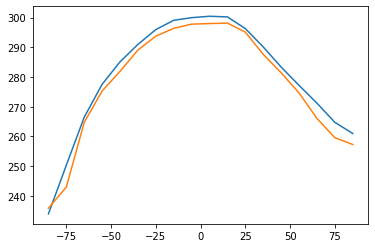

In [30]:
plt.plot(Vars.Lat,HadCM3[1][-1]+elevation)
plt.plot(Lat_10,ZMT_10)
#plt.plot(HadCM3_GMT[0],HadCM3_GMT[1])
#plt.plot(HadCM3[0][1:]/(365*86400),HadCM3[2][1:]+np.average(elevation, weights=cosd(Vars.Lat)))
#plt.scatter()
print(np.average(HadCM3[1][-1]+elevation,weights=cosd(Vars.Lat)))
print(np.mean(HadCM3[2][1:]+np.average(elevation, weights=cosd(Vars.Lat))))

In [ ]:
"""Import the configuration that is required to run your specific model"""

config_HadCM3=importer('Experiments/HadCM3/Config_HadCM3.ini')
parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_HadCM3,initialZMT=False,parallel=True,parallel_config=parallel_config)
config_HadCM3,Sellers=add_sellersparameters(config_HadCM3, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)


"""Import the class of your model that has to be defined in ZOEE.modules.optimization. And give it whatever 
configuration it requires"""

parameter_labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
parameter_levels=np.array([None,None,None,None,None,None])
elevation=-0.0065*np.array(Sellers[1][1])
ZOEE_HadCM3 = ZOEE_optimization(6,'Coupled',parameter_labels,parameter_levels,True,elevation,monthly=True)
#model_setup=[2,'ZMT',parameter_labels,parameter_levels,elevation,True]

"""Execture optimize to start the optimization, giving it your model imported in the step before and configuration
required to run your model"""
optimization_setup.target={'ZMT':ZMT_10,'GMT':HadCM3_GMT}
optimization_setup.num_data=12000
optimization_setup.response=False
F_HadCM3, dF_HadCM3, P_HadCM3, Ptrans_HadCM3, gamma_HadCM3, data_HadCM3=optimization_setup.optimize(ZOEE_HadCM3,config_HadCM3)

Loading Configuration from: Experiments/HadCM3/Config_HadCM3.ini
Loading Parameters from: ZOEE_transition/Data/SellersParameterization.ini


Iteration no.0
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


/home/benni/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 50049 steps, within 262.26863622665405 seconds



In [ ]:
np.savetxt('Experiments/Output/HadCM3_P_20.txt',[P_HadCM3[-1],np.tile(gamma_HadCM3,6)],delimiter=',')
np.savetxt('Experiments/Output/HadCM3_F_20.txt',[F_HadCM3[-1],dF_HadCM3],delimiter=',')
np.savetxt('Experiments/Output/HadCM3_ZMT_20.txt',data_HadCM3[0][:,0],delimiter=',')
np.savetxt('Experiments/Output/HadCM3_GMT_20.txt',data_HadCM3[1][:,0],delimiter=',')

# CESM

In [ ]:
CESM_GMT=np.loadtxt('Experiments/CESM/CESM_850_1850.txt',delimiter=',')

In [ ]:
"""Import the configuration that is required to run your specific model"""

config_CESM=importer('Experiments/CESM/Config_CESM.ini')
parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_CESM,initialZMT=False,parallel=True,parallel_config=parallel_config)
config_CESM,Sellers=add_sellersparameters(config_CESM, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)


"""Import the class of your model that has to be defined in ZOEE.modules.optimization. And give it whatever 
configuration it requires"""

parameter_labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
parameter_levels=np.array([None,None,None,None,None,None])
elevation=-0.0065*np.array(Sellers[1][1])
ZOEE_CESM = ZOEE_optimization(6,'Coupled',parameter_labels,parameter_levels,elevation,monthly=False)
#model_setup=[2,'ZMT',parameter_labels,parameter_levels,elevation,True]

"""Execture optimize to start the optimization, giving it your model imported in the step before and configuration
required to run your model"""
optimization_setup.target={'ZMT':ZMT_10,'GMT':CESM_GMT}
optimization_setup.num_data=1000
optimization_setup.response=False
F_CESM, dF_CESM, P_CESM, Ptrans_CESM, gamma_CESM, data_CESM=optimization_setup.optimize(ZOEE_CESM,config_CESM)

In [ ]:
np.savetxt('Experiments/Output/CESM_P_20.txt',[P_CESM[-1],np.tile(gamma_CESM,6)],delimiter=',')
np.savetxt('Experiments/Output/CESM_F_20.txt',[F_CESM[-1],dF_CESM],delimiter=',')
np.savetxt('Experiments/Output/CESM_ZMT_20.txt',data_CESM[0][:,0],delimiter=',')
np.savetxt('Experiments/Output/CESM_GMT_20.txt',data_CESM[1][:,0],delimiter=',')

# Pages2k

In [ ]:
Pages_GMT=np.loadtxt('Experiments/Pages2k/Pages_850_1850.txt',delimiter=',')

In [ ]:
"""Import the configuration that is required to run your specific model"""

config_Pages=importer('Experiments/Pages2k/Config_Pages.ini')
parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_Pages,initialZMT=False,parallel=True,parallel_config=parallel_config)
config_Pages,Sellers=add_sellersparameters(config_Pages, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)


"""Import the class of your model that has to be defined in ZOEE.modules.optimization. And give it whatever 
configuration it requires"""

parameter_labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
parameter_levels=np.array([None,None,None,None,None,None])
elevation=-0.0065*np.array(Sellers[1][1])
ZOEE_Pages = ZOEE_optimization(6,'Coupled',parameter_labels,parameter_levels,elevation,monthly=True)
#model_setup=[2,'ZMT',parameter_labels,parameter_levels,elevation,True]

"""Execture optimize to start the optimization, giving it your model imported in the step before and configuration
required to run your model"""
optimization_setup.target={'ZMT':ZMT_10,'GMT':Pages_GMT}
optimization_setup.num_data=12000
optimization_setup.response=True
F_Pages, dF_Pages, P_Pages, Ptrans_Pages, gamma_Pages, data_Pages=optimization_setup.optimize(ZOEE_Pages,config_Pages)

In [ ]:
np.savetxt('Experiments/Output/Pages_P_20.txt',[P_Pages[-1],np.tile(gamma_Pages,6)],delimiter=',')
np.savetxt('Experiments/Output/Pages_F_20.txt',[F_Pages[-1],dF_Pages],delimiter=',')
np.savetxt('Experiments/Output/Pages_ZMT_20.txt',data_Pages[0][:,0],delimiter=',')
np.savetxt('Experiments/Output/Pages_GMT_20.txt',data_Pages[1][:,0],delimiter=',')

In [ ]:
x=np.array([[2,2],[2,2],[2,2]])
(x-np.array([2,2])).shape